In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/GoldenSnow-Xue/Schulich_Data_Science_Dataset/main/data_set_hackathon.csv")

In [3]:
df.describe()

,Customer Order Code,value
count,2.420000e+03,2420.000000
mean,3.200672e+09,1162.976624
std,1.004408e+05,2560.595118
min,3.200435e+09,-0.030000
25%,3.200614e+09,33.030000
50%,3.200711e+09,70.490000
75%,3.200729e+09,1363.200000
max,3.201062e+09,38937.500000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB


In [5]:
df.head(10)

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001
5,20.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435982,2173.12,RUB,5,RU0001
6,20.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436075,3344.00,RUB,8,RU0001
7,20.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436082,3158.75,RUB,7,RU0001
8,21.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436158,7068.00,RUB,16,RU0001
9,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200436332,2550.75,RUB,6,RU0001


##### 1. Data Cleaning

In [6]:
# Convert 'order_date' and 'requested_delivery_date' to datetime
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y')
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'], format='%d.%m.%Y')

# Convert 'items' to numeric
df['items'] = pd.to_numeric(df['items'], errors='coerce')

In [8]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

order_date                   0
requested_delivery_date      0
Customer Country Code        0
Product Code                 0
Description                  0
order_type                   0
Customer Order Code          0
value                        0
Curr                         0
items                      346
Route                        0
dtype: int64

In [11]:
# Group by 'Product Code' and 'Customer Country Code' and calculate median
grouped_medians = df.groupby(['Product Code', 'Customer Country Code'])['items'].median()

# Function to impute missing values based on grouped medians
def impute_missing_items(row):
    if pd.isna(row['items']):
        return grouped_medians.get((row['Product Code'], row['Customer Country Code']))
    else:
        return row['items']

# Apply the function to the dataset
df['items'] = df.apply(impute_missing_items, axis=1)

# Check if there are still missing values after imputation
missing_values_after_imputation = df['items'].isnull().sum()

missing_values_after_imputation


47

In [13]:
# Calculate the overall median for the 'items' column
overall_median = df['items'].median()

# Impute the remaining missing values with the overall median
df['items'].fillna(overall_median, inplace=True)

# Re-check if there are any missing values left
remaining_missing_values = df['items'].isnull().sum()
remaining_missing_values, overall_median

(0, 6.0)

##### 2. Exploratory Data Analysis (EDA)

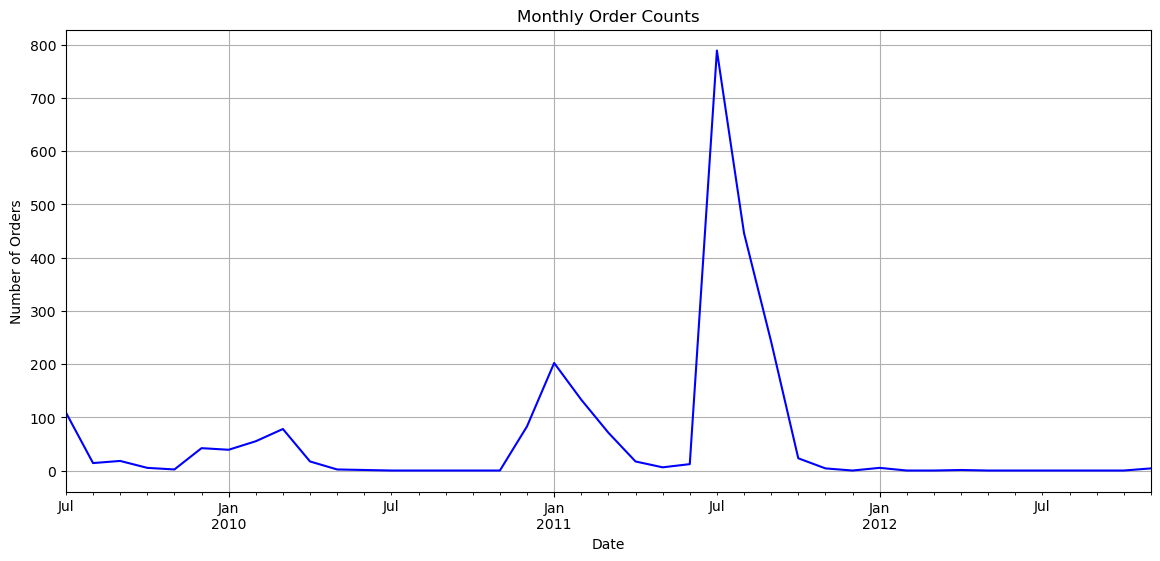

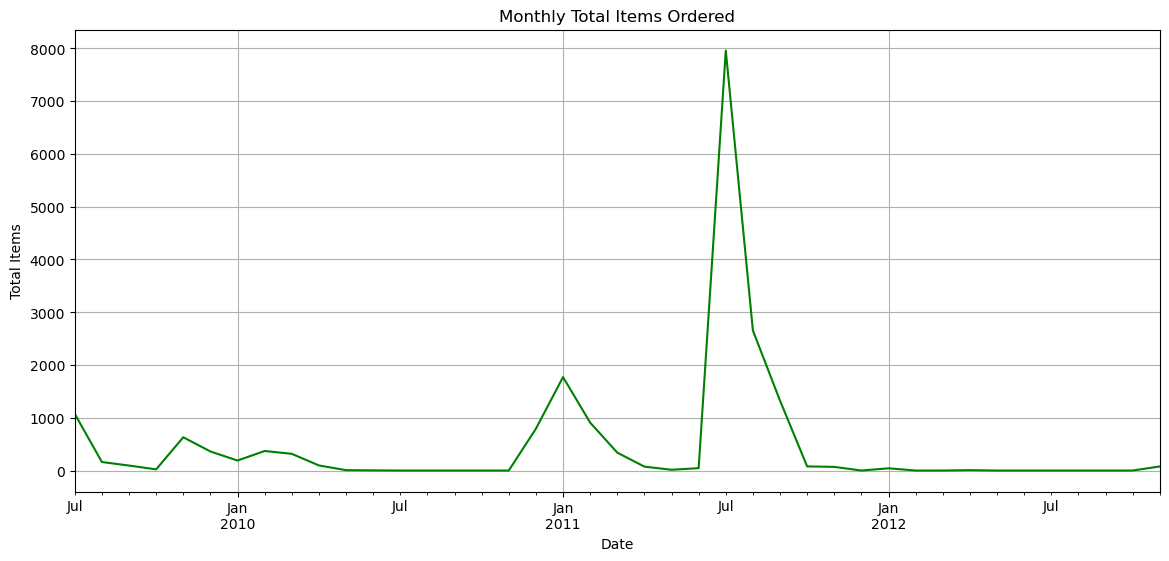

In [14]:
import matplotlib.pyplot as plt

# Setting the figure size for the plots
plt.rcParams['figure.figsize'] = [14, 6]

# Create a monthly time series of order counts
monthly_order_counts = df.set_index('order_date').resample('M').size()

# Create a monthly time series of the total number of items ordered
monthly_items_sum = df.set_index('order_date').resample('M')['items'].sum()

# Plotting the monthly order counts
plt.figure(1)
monthly_order_counts.plot(title='Monthly Order Counts', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

# Plotting the monthly total number of items ordered
plt.figure(2)
monthly_items_sum.plot(title='Monthly Total Items Ordered', color='green')
plt.xlabel('Date')
plt.ylabel('Total Items')
plt.grid(True)
plt.show()


##### 3. Aggregate Demand Analysis

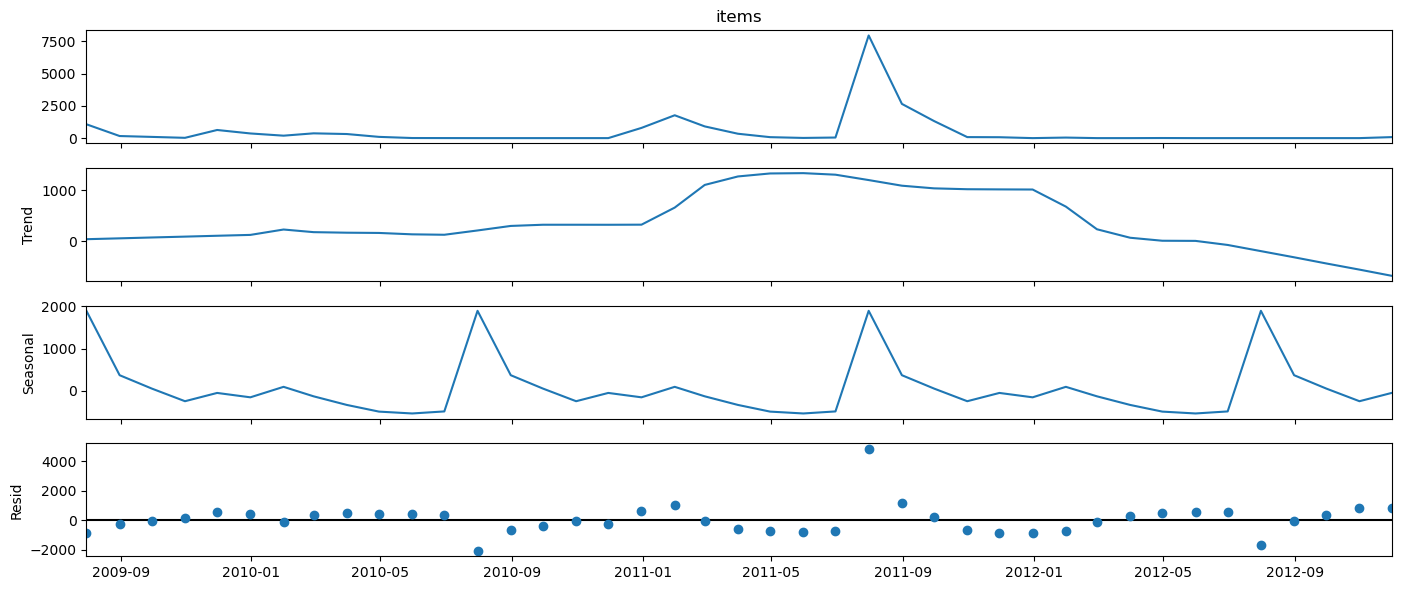

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate the total number of items ordered on a monthly basis for all products
total_monthly_demand = df.set_index('order_date').resample('M')['items'].sum()

# Decompose the time series using STL
decomposition = seasonal_decompose(total_monthly_demand, model='additive', extrapolate_trend='freq')

# Plotting the decomposed time series components
decomposition.plot()
plt.show()

In [18]:
# Calculate the lead time (in days)
df['lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

In [19]:
# Extract month from 'order_date' and 'requested_delivery_date' to capture seasonal effects
df['order_month'] = df['order_date'].dt.month
df['delivery_month'] = df['requested_delivery_date'].dt.month

In [20]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the categorical features
categorical_features = df[['Customer Country Code', 'Curr', 'Route']]
encoder = OneHotEncoder(sparse=False)
encoded_categorical_features = encoder.fit_transform(categorical_features)

c:\Users\Golden Snow\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
# Combine the encoded categorical features with the numeric features
numeric_features = df[['value', 'lead_time', 'order_month', 'delivery_month']].to_numpy()
X = np.hstack((encoded_categorical_features, numeric_features))

In [24]:
# Define 'target_sku' as the first product code in the dataset for demonstration purposes
target_sku = df['Product Code'].unique()[0]

In [26]:
# Create a binary target variable for the chosen SKU
df['target'] = (df['Product Code'] == target_sku).astype(int)

In [27]:
# The target variable for the first product code
y = df['target'].to_numpy()

In [28]:
# Check the shape of the features and target arrays
print(X.shape, y.shape)

(2420, 78) (2420,)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Split the encoded features and target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the logistic regression model for the first SKU
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)  # Training for the first SKU

# Predicting the test set results and calculating the accuracy
y_pred = logreg.predict(X_test)

# Evaluating the model
report = classification_report(y_test, y_pred, output_dict=True)

report

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 483.0},
 '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 484.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 484.0}}

In [30]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


SyntaxError: invalid syntax (498079137.py, line 1)

In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Assuming X and y are already defined as before

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Training the logistic regression model on the balanced dataset
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_smote, y_train_smote)

# Predicting the test set results
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)

conf_matrix, roc_auc

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (c:\Users\Golden Snow\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py)